## Bayesian Neural Networks in Keras and TensorFlow 2.0

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tfd = tfp.distributions

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print('TensorFlow version (expected = 2.0.0-beta1):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0-beta1): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190912


## We are all set up, lets go!

We are using MNIST dataset!
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


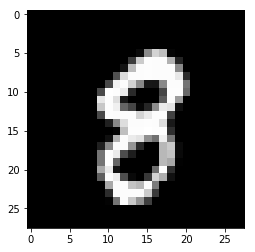

In [11]:
"""
first, we load the dataset. We are trying to do it first with MNIST
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using MNIST dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, 0], cmap='gist_gray')

In [12]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    

In [58]:
def build_bayesian_bcnn_model(input_shape):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

In [120]:
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [121]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss_en = tf.nn.softmax_cross_entropy_with_logits(labels=y_train, logits=logits)
        loss_kl = tf.keras.losses.KLD(y_train, logits)
        loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(y_train, axis=1))

In [ ]:
for i in range(16, 21):
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    print("Epoch: {}: loss = {} , accuracy = {}".format(i, loss, acc))

Epoch: 16: loss = 1.7340199947357178 , accuracy = 0.55365
Epoch: 17: loss = 1.485308051109314 , accuracy = 0.6606666666666666
Epoch: 18: loss = 1.189466118812561 , accuracy = 0.6767666666666666
Epoch: 19: loss = 1.068599820137024 , accuracy = 0.7241666666666666
